In [67]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler,normalize

In [68]:
(y_train-min(y_train))/(max(y_train)-min(y_train))

array([0.00723592, 0.01415619, 0.0091467 , ..., 0.5772105 , 0.4472048 ,
       0.30385637], dtype=float32)

In [69]:
source = "../data_source/present_data.csv"

In [70]:
dataf = pd.read_csv(source)

In [71]:
f_dataf = dataf.dropna()
f_dataf.shape

(1912, 13)

In [72]:
pars = list(f_dataf.columns)
print(pars)

['Unnamed: 0', 'latitude', 'longitude', 't_winter', 't_spring', 't_summer', 't_fall', 'p_winter', 'p_spring', 'p_summer', 'p_fall', 'carb', 'veg']


In [73]:
f_dataf

,Unnamed: 0,latitude,longitude,t_winter,t_spring,t_summer,t_fall,p_winter,p_spring,p_summer,p_fall,carb,veg
0,0,32.5625,243.0625,13.209499,16.019327,21.191208,18.987041,1.781894,0.927823,0.079056,0.425362,1.498861,1.0
1,1,32.5625,243.1875,11.126074,14.355422,20.732061,17.534286,2.167904,1.174322,0.117344,0.646820,2.763761,1.0
2,2,32.6875,243.0625,13.274010,16.141298,21.413210,19.143139,1.801917,0.915378,0.073457,0.446339,1.848117,1.0
3,3,32.6875,243.1875,12.192781,15.664566,22.704735,19.012733,2.169224,1.197534,0.113007,0.653634,5.562317,1.0
4,4,32.6875,243.3125,9.981687,13.987834,22.163626,17.377697,2.418175,1.320502,0.172150,0.723509,6.725700,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2242,41.9375,237.4375,2.324508,9.342533,19.433820,11.060002,3.026568,0.989328,0.449903,1.093923,22.685206,1.0
2243,2243,41.9375,237.5625,3.219994,10.196562,20.260645,11.946576,2.297202,0.820435,0.452079,0.942086,10.326124,1.0
2244,2244,41.9375,237.6875,1.430400,8.375308,18.383022,10.134927,2.848567,1.277118,0.556918,1.222243,30.629481,1.0
2245,2245,41.9375,237.8125,-0.237994,6.859822,16.808168,8.492342,2.381254,1.033747,0.545428,0.877401,46.384072,2.0


In [94]:

data_np = f_dataf.to_numpy(dtype="float32")
x_train = data_np[:1600,3:-2]
x_val = data_np[1600:,3:-2]

##### Specify the label category -1 for veg classification and -2 for carb regression
y_train = data_np[:1600,-1]
y_val = data_np[1600:,-1]

## Normalize the input data
# sc = StandardScaler()
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
y_train = (y_train-min(y_train))/(max(y_train)-min(y_train)) 

x_val = sc.fit_transform(x_val)
y_val = (y_val-min(y_val))/(max(y_val)-min(y_val))


print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return self.length

trainset = dataset(x_train,y_train)
valset = dataset(x_val,y_val)
#DataLoader
trainloader = DataLoader(trainset,batch_size=16,shuffle=False)
valloader = DataLoader(valset,batch_size=16,shuffle=False)



(1600, 8) (1600,)
(312, 8) (312,)


In [132]:
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

x = torch.tensor(x_train)  # x data (tensor), shape=(100, 1)
y = torch.tensor(y_train)                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
# The code below is deprecated in Pytorch 0.4. Now, autograd directly supports tensors
# x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net1(nn.Module):

  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    # self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(32,1)
    # self.y_class = nn.Linear(32,1)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    # x = torch.relu(self.fc2(x))
    # x = torch.sigmoid(self.fc3(x))
    x = self.fc3(x)
    x = torch.sigmoid(x)
   
    return x


net = Net(x.shape[1])     # define the network
# if torch.cuda.is_available():
#     print("using Gpu")
#     net = net.cuda()
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.005)
reg_loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
class_loss_func = torch.nn.BCELoss()  # the target label is NOT an one-hotted



Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (y_class): Linear(in_features=32, out_features=1, bias=True)
)


In [133]:
train_losses = []
train_accur = []
val_losses = []
val_accur = []

for i in range(600):
  for j,(x,y) in enumerate(trainloader):
    
    #calculate output
    output = net(x)
 
    #calculate loss
    train_loss = class_loss_func(output,y.reshape(-1,1))
 
    # loss = reg_loss_func(output,y )
 
    #class accuracy
    
    predicted = net(torch.tensor(x_train, dtype=torch.float32))
    train_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

    #backprop
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  for j,(x,y) in enumerate(valloader):

    val_output = net(x)
 
    #calculate loss
    val_loss = class_loss_func(val_output,y.reshape(-1,1))

    #class accuracy
    
    predicted = net(torch.tensor(x_train, dtype=torch.float32))
    val_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()


  if i%10 == 0:
    train_losses.append(train_loss.data)
    train_accur.append(train_acc)
    val_losses.append(val_loss.data)
    val_accur.append(val_acc)
    print("epoch {:<5} train_loss:{:5f} val_loss: {:5f} train_accuracy:{:5f} val_accuracy: {:5f}".format(i,train_loss,val_loss,train_acc,val_acc))

epoch 0     train_loss:0.749197 val_loss: 0.710485 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 10    train_loss:0.830021 val_loss: 0.830542 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 20    train_loss:0.634375 val_loss: 0.822267 train_accuracy:0.821875 val_accuracy: 0.821875
epoch 30    train_loss:0.502546 val_loss: 0.831302 train_accuracy:0.857500 val_accuracy: 0.856250
epoch 40    train_loss:0.415513 val_loss: 0.861336 train_accuracy:0.871875 val_accuracy: 0.872500
epoch 50    train_loss:0.362483 val_loss: 0.907324 train_accuracy:0.878125 val_accuracy: 0.878125
epoch 60    train_loss:0.331216 val_loss: 0.965098 train_accuracy:0.883125 val_accuracy: 0.883125
epoch 70    train_loss:0.313819 val_loss: 1.025578 train_accuracy:0.883750 val_accuracy: 0.883750
epoch 80    train_loss:0.303080 val_loss: 1.086758 train_accuracy:0.883750 val_accuracy: 0.883750
epoch 90    train_loss:0.295750 val_loss: 1.145044 train_accuracy:0.886250 val_accuracy: 0.886250
epoch 100   train_lo

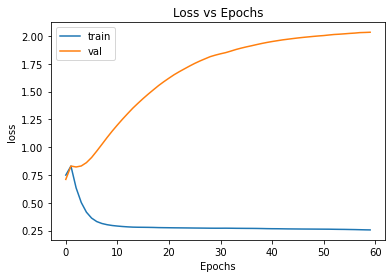

In [134]:

plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

Text(0, 0.5, 'loss')

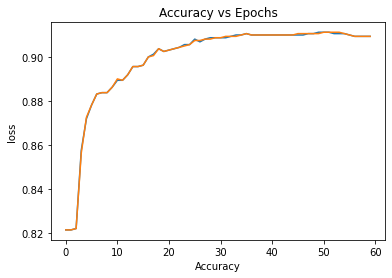

In [137]:
plt.plot(train_accur,label='train')
plt.plot(val_accur,label='val')
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [91]:
# x = x.type(torch.long)
# x.dtype

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [92]:
for t in range(100):
    print(x.dtype)
    y_reg, y_class = net(x)     # input x and predict based on x
    print(y_reg.shape,y_class.shape)
    # reg_loss = reg_loss_func(y_reg, y)     # must be (1. nn output, 2. target)
    class_loss = class_loss_func(y_class, y[:,1])
    loss_sum = class_loss
    # loss_sum = reg_loss+class_loss
    optimizer.zero_grad()   # clear gradients for next train
    loss_sum.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy()[:,0], y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

torch.float32
torch.Size([1600, 1]) torch.Size([1600, 1])


RuntimeError: expected scalar type Long but found Float

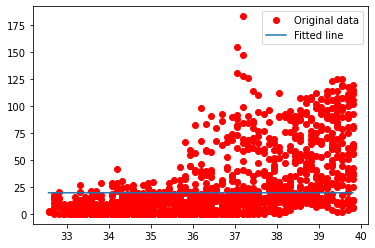

In [30]:
predicted = net(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train[:,0], y_train, 'ro', label='Original data')
plt.plot(x_train[:,0], predicted, label='Fitted line')
plt.legend()
plt.show()

(1600, 8) (1600, 1) (1600, 1)
Net(
  (hidden): Linear(in_features=8, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (predict_class): Linear(in_features=32, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predict_reg): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
x:torch.Size([1600, 8]) y1:torch.Size([1600, 1]) y2:torch.Size([1600, 1])y1_train:(1600, 1)y2_train(1600, 1)
tensor(0.7489, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.4648, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1769, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-0.1678, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-0.5984, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-1.1760, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-2.0008, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-3

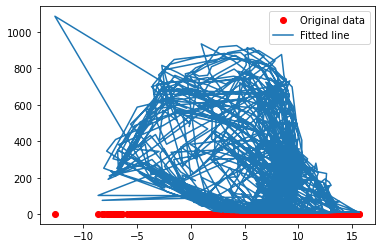